In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [63]:
x, y = make_blobs(1000,n_features=2, centers=4, cluster_std=2.5,random_state=33)

In [64]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

In [65]:
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3)

In [66]:
xtrain[0]

tensor([ 8.6004, -5.4508])

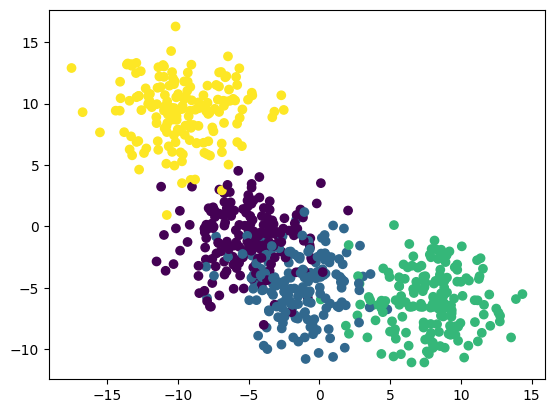

In [67]:
plt.scatter(xtrain[:,0],xtrain[:,1], c=ytrain)

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
xtrain, ytrain = xtrain.to(device), ytrain.to(device)
xtest, ytest = xtest.to(device), ytest.to(device)

In [70]:
class MultiClass(nn.Module):
    def __init__(self):
        super().__init__()
        self.network_layers = nn.Sequential(
                nn.Linear(in_features=2, out_features=10),
                nn.ReLU(),
                nn.Linear(in_features=10, out_features=10),
                nn.ReLU(),
                nn.Linear(in_features=10, out_features=4)                
        )

    def forward(self, x):
        return self.network_layers(x)
    
model = MultiClass()
model = model.to(device)
model

MultiClass(
  (network_layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [71]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(),lr=0.1)

In [75]:
def cal_accuracy(pred, ytrue):
    acc = (pred==ytrue).sum().item()
    acc = (acc/len(ytrue)) * 100
    return acc

In [101]:
torch.manual_seed(33)
torch.cuda.manual_seed(33)

epochs = 100

for i in range(0,11):
    model.train() # train the model

    logits = model(xtrain) # Forward Pass
    probs = torch.softmax(logits,dim=1) # Probability value
    prediction = torch.argmax(probs,dim=1) # Prediction

    acc = cal_accuracy(prediction, ytrain) 
    loss = loss_fn(logits, ytrain) # Calculate the loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epochs {i+1} Loss: {loss.item():.5f}, Accuracy: {acc:.5f}")

Epochs 1 Loss: 0.20134, Accuracy: 91.28571
Epochs 2 Loss: 0.20135, Accuracy: 91.42857
Epochs 3 Loss: 0.20143, Accuracy: 91.28571
Epochs 4 Loss: 0.20142, Accuracy: 91.28571
Epochs 5 Loss: 0.20123, Accuracy: 91.28571
Epochs 6 Loss: 0.20132, Accuracy: 91.42857
Epochs 7 Loss: 0.20125, Accuracy: 91.42857
Epochs 8 Loss: 0.20114, Accuracy: 91.42857
Epochs 9 Loss: 0.20119, Accuracy: 91.28571
Epochs 10 Loss: 0.20111, Accuracy: 91.42857
Epochs 11 Loss: 0.20109, Accuracy: 91.42857


In [102]:
# make predictions using test data
model.eval()
with torch.inference_mode():
    logits = model(xtest)
    prob = torch.softmax(logits,dim=1).argmax(dim=1)
    acc = cal_accuracy(prob, ytest)
    print(f"Training accuracy: {acc:.3f}")

Training accuracy: 91.333


In [103]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

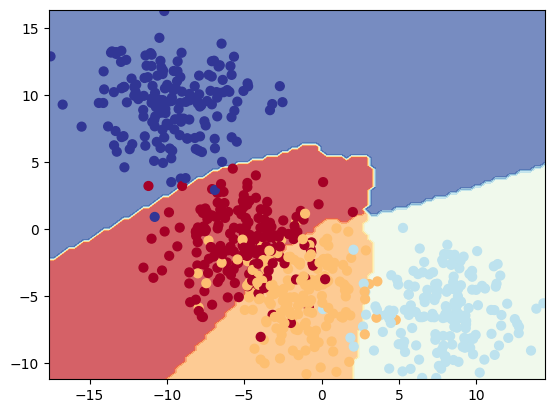

In [104]:
plot_decision_boundary(model,xtrain,ytrain)

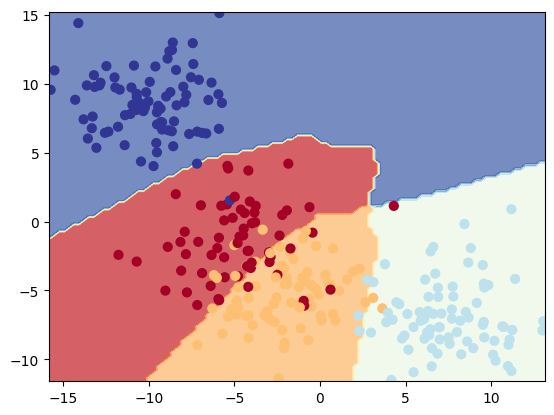

In [105]:
plot_decision_boundary(model,xtest,ytest)